In [1]:
!pip install patchify

In [2]:
!pip install matplotlib

In [3]:
!pip install patchify

In [7]:
!pip install math 


ERROR: Could not find a version that satisfies the requirement math (from versions: none)
ERROR: No matching distribution found for math


In [1]:
# IMPORTS
import matplotlib.image
import math
import random 
import PIL
from PIL import Image, ImageDraw
import numpy as np
from itertools import chain
import cv2
from matplotlib import pyplot as plt
import subprocess
import threading 
import sys
from os import path
from keras.utils import normalize
from patchify import patchify, unpatchify


import os

In [11]:
l=['thm_dir_N-30_090.png', 'thm_dir_N-30_120.png', 'thm_dir_N-30_150.png', 'thm_dir_N-30_180.png', 'thm_dir_N-30_210.png', 'thm_dir_N-30_240.png', 'thm_dir_N-30_270.png', 'thm_dir_N-30_300.png', 'thm_dir_N-30_330.png', 'thm_dir_N00_000.png', 'thm_dir_N00_030.png', 'thm_dir_N00_060.png', 'thm_dir_N00_090.png', 'thm_dir_N00_120.png', 'thm_dir_N00_150.png', 'thm_dir_N00_180.png', 'thm_dir_N00_210.png', 'thm_dir_N00_240.png', 'thm_dir_N00_270.png', 'thm_dir_N00_300.png', 'thm_dir_N00_330.png']

In [3]:
def reconstruct_images(patches):
  reconstructed_image = unpatchify(patches, (7680,7680))
  return reconstructed_image

In [3]:
def get_image_source_list(source):
   l=os.listdir(source)
   return l
def return_slised_image(large_image):
  patches = patchify(large_image, (512, 512), step=512)  
  return patches

In [5]:
def convert_grey(img):
  return img.convert("L")

In [6]:
def get_pixels(images)  :
  l=[]
  for x in range(512):
    for y in range(512):
      pos = (x, y)
      rgba = images[x][y]
      if rgba==0  :
        l.append((x,y))
  return l

In [7]:
def get_neighboring_pixel(img, x, y, current_window_size):
  """ 
  Dynamically selects non-missing points within a radius of the target missing pixel. As selection fails, radius size increases automatically.
  Inputs: img (numpy array)
          x, y: coordinates of the target missing pixel to fill
  Outputs: dynamically-selected non-missing pixel (x_neighbor, y_neighbor)
  """
  x_rand, y_rand = 0,0
  max_num_tries = 10000000000
  max_tries_per_neighbourhood = 1000
  neighbourhood_size_increment = 50
  current_window_size = 10
  total_tries = 0
  for _ in range(math.ceil(max_num_tries/max_tries_per_neighbourhood)):
    for _ in range(max_tries_per_neighbourhood):
      min_x = max(0, x-current_window_size)
      max_x = min(512, x+current_window_size)
      min_y = max(0, y-current_window_size)
      max_y = min(512, y+current_window_size)
      x_rand = random.randint(min_x, max_x-1)
      y_rand = random.randint(min_y, max_y-1)
      total_tries += 1
      if not img[x_rand][y_rand]==0 :
        return x_rand, y_rand
    current_window_size += neighbourhood_size_increment

  return x_rand, y_rand

In [8]:
def fill_swath_with_neighboring_pixel(img, left=10, right=100, top=10, bottom=100, color = {0,0,0}, current_window_size = 10):
  """ 
  Filling method 3: 
  Input: image with missing data (numpy array)
  Output: numpy array with missing data filled by random RGB values from non-missing pixel portions of the image selected with probability inversely proportional to distance
  """
  img_with_neighbor_filled = np.array(img.copy())
  l=get_pixels(img)
  for k in l:
    x,y=k
    x_rand, y_rand = get_neighboring_pixel(img, x, y, current_window_size)
    if x >= left and x <= right and y >= top and y <= bottom:
      img_with_neighbor_filled[x][y] = img[x_rand][y_rand]
  return img_with_neighbor_filled

In [8]:
def generate_border(image, border_size=5, n_erosions=1):

    erosion_kernel = np.ones((3,3), np.uint8)      ## Start by eroding edge pixels
    eroded_image = cv2.erode(image, erosion_kernel, iterations=n_erosions)  
 
    ## Define the kernel size for dilation based on the desired border size (Add 1 to keep it odd)
    kernel_size = 2*border_size + 1 
    dilation_kernel = np.ones((kernel_size, kernel_size), np.uint8)   #Kernel to be used for dilation
    dilated  = cv2.dilate(eroded_image, dilation_kernel, iterations = 1)
    #plt.imshow(dilated, cmap='gray')
    
    ## Replace 255 values to 127 for all pixels. Eventually we will only define border pixels with this value
    dilated_127 = np.where(dilated == 255, 127, dilated) 	
    
    #In the above dilated image, convert the eroded object parts to pixel value 255
    #What's remaining with a value of 127 would be the boundary pixels. 
    original_with_border = np.where(eroded_image > 127, 255, dilated_127)
    
    #plt.imshow(original_with_border,cmap='gray')
    
    return original_with_border

In [22]:


def save_target_image_with_border(source,taget_images,target_with_border_folder):
    for image in taget_images:
        img= cv2.imread(os.path.join(source,image), cv2.IMREAD_GRAYSCALE)  #now, we can read each file since we have the full path    
        #process each image
        processed_image = generate_border(img, border_size=5, n_erosions=1)
        #Save images with same name as original image/mask
        print(os.path.join(target_with_border_folder, image))
        matplotlib.image.imsave(os.path.join(target_with_border_folder, image+"with_border.png"),processed_image)
        print("Finished processing image ", img)   

In [10]:
source=r"C:\Users\DELL\cs_challange\data\preprossed_data"  # w lina zada 7ot nafse 
l_data=get_image_source_list(source)# 7ote dossier yali fih original photo imta3kim
print(l_data)


['thm_dir_N-30_000.pnggood_image.png', 'thm_dir_N-30_030.pnggood_image.png', 'thm_dir_N-30_060.pnggood_image.png', 'thm_dir_N-30_090.pnggood_image.png', 'thm_dir_N-30_120.pnggood_image.png', 'thm_dir_N-30_150.pnggood_image.png', 'thm_dir_N-30_180.pnggood_image.png', 'thm_dir_N-30_210.pnggood_image.png', 'thm_dir_N-30_240.pnggood_image.png', 'thm_dir_N-30_270.pnggood_image.png', 'thm_dir_N-30_300.pnggood_image.png', 'thm_dir_N-30_330.pnggood_image.png', 'thm_dir_N00_000.pnggood_image.png', 'thm_dir_N00_030.pnggood_image.png', 'thm_dir_N00_060.pnggood_image.png', 'thm_dir_N00_090.pnggood_image.png', 'thm_dir_N00_120.pnggood_image.png', 'thm_dir_N00_150.pnggood_image.png', 'thm_dir_N00_180.pnggood_image.png', 'thm_dir_N00_210.pnggood_image.png', 'thm_dir_N00_240.pnggood_image.png', 'thm_dir_N00_270.pnggood_image.png', 'thm_dir_N00_300.pnggood_image.png', 'thm_dir_N00_330.pnggood_image.png']


In [24]:
target_source=r"C:\Users\DELL\cs_challange\data\target_data"
l_target=get_image_source_list(target_source)
print(l_target)
target_with_border_folder=r"C:\Users\DELL\cs_challange\target_with_border"

['thm_dir_N-30_000_-30_0_0_30_2_32_km_segrng.png', 'thm_dir_N-30_030_-30_0_30_60_2_32_km_segrng.png', 'thm_dir_N-30_060_-30_0_60_90_2_32_km_segrng.png', 'thm_dir_N-30_090_-30_0_90_120_2_32_km_segrng.png', 'thm_dir_N-30_120_-30_0_120_150_2_32_km_segrng.png', 'thm_dir_N-30_150_-30_0_150_180_2_32_km_segrng.png', 'thm_dir_N-30_180_-30_0_-180_-150_2_32_km_segrng.png', 'thm_dir_N-30_210_-30_0_-150_-120_2_32_km_segrng.png', 'thm_dir_N-30_240_-30_0_-120_-90_2_32_km_segrng.png', 'thm_dir_N-30_270_-30_0_-90_-60_2_32_km_segrng.png', 'thm_dir_N-30_300_-30_0_-60_-30_2_32_km_segrng.png', 'thm_dir_N-30_330_-30_0_-30_0_2_32_km_segrng.png', 'thm_dir_N00_000_0_30_0_30_2_32_km_segrng.png', 'thm_dir_N00_030_0_30_30_60_2_32_km_segrng.png', 'thm_dir_N00_060_0_30_60_90_2_32_km_segrng.png', 'thm_dir_N00_090_0_30_90_120_2_32_km_segrng.png', 'thm_dir_N00_120_0_30_120_150_2_32_km_segrng.png', 'thm_dir_N00_150_0_30_150_180_2_32_km_segrng.png', 'thm_dir_N00_180_0_30_-180_-150_2_32_km_segrng.png', 'thm_dir_N00_210_

In [ ]:
save_target_image_with_border(target_source,l_target,target_with_border_folder)

C:\Users\DELL\cs_challange\target_with_border\thm_dir_N-30_000_-30_0_0_30_2_32_km_segrng.png
Finished processing image  [[255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
C:\Users\DELL\cs_challange\target_with_border\thm_dir_N-30_030_-30_0_30_60_2_32_km_segrng.png
Finished processing image  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
C:\Users\DELL\cs_challange\target_with_border\thm_dir_N-30_060_-30_0_60_90_2_32_km_segrng.png
Finished processing image  [[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
C:\Users\DELL\cs_challange\target_with_border\thm_dir_N-30_090_-30_0_90_120_2_32_km_segrng.png
Finished processing image  [[0 0 0 ... 

In [13]:
def get_train_images(patches,patches_target):
  x_train=[]
  y_train=[]
  for i in range(15):
    for j in range(15):
      x_train.append(patches[i][j])
      y_train.append(patches_target[i][j])
  return x_train,y_train

In [14]:
def get_train_test_data(l_target,l_data,source,target_source):
    x_train=[]
    y_train=[]
    x_test=[]
    y_test=[]
    for x in range(24):
        x_image=cv2.imread(os.path.join(source,l_data[x]),0)
        y_image=cv2.imread(os.path.join(target_source,l_target[x]),0)
        x_patches=return_slised_image(x_image)
        y_patches=return_slised_image(y_image)
        l,s=get_train_images(x_patches,y_patches)
        if x<19:
            x_train=x_train+l
            y_train=y_train+s
        else:
            x_test=x_test+l
            y_test=y_test+s
    x_train=np.array(x_train)
    x_train=x_train/255.0
    y_train=np.array(y_train)
    y_train=y_train/255.0
    x_test=np.array(x_test)
    x_test=x_test/255.0
    y_test=np.array(y_test)
    y_test=y_test/255.0
    return x_train,x_test,y_train,y_test
       
        

In [ ]:
x_train,x_test,y_train,y_test=get_train_test_data(l_target,l_data,source,target_source)

In [10]:
print(l)

['.ipynb_checkpoints', 'thm_dir_N-30_030.png', 'thm_dir_N-30_030.pnggood_image.png', 'thm_dir_N-30_060.png', 'thm_dir_N-30_060.pnggood_image.png', 'thm_dir_N-30_090.png', 'thm_dir_N-30_120.png', 'thm_dir_N-30_150.png', 'thm_dir_N-30_180.png', 'thm_dir_N-30_210.png', 'thm_dir_N-30_240.png', 'thm_dir_N-30_270.png', 'thm_dir_N-30_300.png', 'thm_dir_N-30_330.png', 'thm_dir_N00_000.png', 'thm_dir_N00_030.png', 'thm_dir_N00_060.png', 'thm_dir_N00_090.png', 'thm_dir_N00_120.png', 'thm_dir_N00_150.png', 'thm_dir_N00_180.png', 'thm_dir_N00_210.png', 'thm_dir_N00_240.png', 'thm_dir_N00_270.png', 'thm_dir_N00_300.png', 'thm_dir_N00_330.png']


In [ ]:
for img in l:
  large_image=Image.open(os.path.join(source,img))
  im=convert_grey(large_image)
  patches=return_slised_image(np.array(im))
  for i in range(15):
     for j in range(15):
       patches[i][j]=fill_swath_with_neighboring_pixel(patches[i][j], left=0, right=511,top=0, bottom=511, color={0,0,0}, current_window_size=10)
       print("done :",i,j)
  good_image=reconstruct_images(patches)
  good_imagesss.append(good_image)
  plt.imshow(good_image)
  matplotlib.image.imsave(os.path.join(source,img+"good_image.png"), good_image) 


done : 0 0
done : 0 1
done : 0 2
done : 0 3
done : 0 4
done : 0 5
done : 0 6
done : 0 7
done : 0 8
done : 0 9
done : 0 10
done : 0 11
done : 0 12
done : 0 13
done : 0 14
done : 1 0
done : 1 1
done : 1 2
done : 1 3
done : 1 4
done : 1 5
done : 1 6
done : 1 7
done : 1 8
done : 1 9
done : 1 10
done : 1 11
done : 1 12
done : 1 13
done : 1 14
done : 2 0
done : 2 1
done : 2 2
done : 2 3
done : 2 4
done : 2 5
done : 2 6
done : 2 7
done : 2 8
done : 2 9
done : 2 10
done : 2 11
done : 2 12
done : 2 13
done : 2 14
done : 3 0
done : 3 1
done : 3 2
done : 3 3
done : 3 4
done : 3 5
done : 3 6
done : 3 7
done : 3 8
done : 3 9
done : 3 10
done : 3 11
done : 3 12
done : 3 13
done : 3 14
done : 4 0
done : 4 1
done : 4 2
done : 4 3
done : 4 4
done : 4 5
done : 4 6
done : 4 7
done : 4 8
done : 4 9
done : 4 10
done : 4 11
done : 4 12
done : 4 13
done : 4 14
done : 5 0
done : 5 1
done : 5 2
done : 5 3
done : 5 4
done : 5 5
done : 5 6
done : 5 7
done : 5 8
done : 5 9
done : 5 10
done : 5 11
done : 5 12
done


KeyboardInterrupt



In [75]:
print(l)

['thm_dir_N-30_090.png', 'thm_dir_N-30_120.png', 'thm_dir_N-30_150.png', 'thm_dir_N-30_180.png', 'thm_dir_N-30_210.png', 'thm_dir_N-30_240.png', 'thm_dir_N-30_270.png', 'thm_dir_N-30_300.png', 'thm_dir_N-30_330.png', 'thm_dir_N00_000.png', 'thm_dir_N00_030.png', 'thm_dir_N00_060.png', 'thm_dir_N00_090.png', 'thm_dir_N00_120.png', 'thm_dir_N00_150.png', 'thm_dir_N00_180.png', 'thm_dir_N00_210.png', 'thm_dir_N00_240.png', 'thm_dir_N00_270.png', 'thm_dir_N00_300.png', 'thm_dir_N00_330.png']


In [31]:
large_image = Image.open(r'C:\Users\DELL\cs_challange\data\res2.png')

In [73]:
matplotlib.image.imsave(os.path.join(source,l[0]+"good_image.png"), good_image) 

In [74]:
l=l[1:]

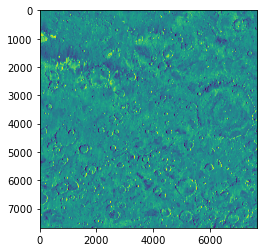

In [68]:
good_image=reconstruct_images(patches)
good_imagesss.append(good_image)
plt.imshow(good_image)
matplotlib.image.imsave(os.path.join(source,l[0]+"good_image.png"), good_image)

In [71]:
print(len(l))

22


In [45]:
print(type(good_image))

<class 'function'>


In [47]:
good_image=unpatchify(patches, (7680,7680))

In [52]:
good_image.imsave(r'C:\Users\DELL\cs_challange\data\res2_good_image.png')

AttributeError: 'numpy.ndarray' object has no attribute 'imsave'

In [53]:

import matplotlib.image

matplotlib.image.imsave(r'C:\Users\DELL\cs_challange\data\res2_good_image.png', good_image)  

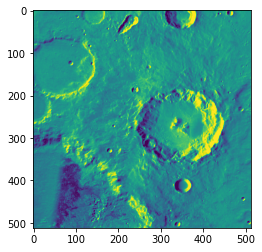

In [50]:
plt.imshow(patches[13][13])

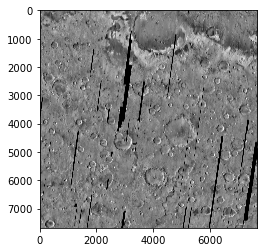

In [32]:
plt.imshow(large_image, cmap='gray')

In [33]:
good_image=get_the_good_photo(large_image)

done : 0 0
done : 0 1
done : 0 2
done : 0 3
done : 0 4
done : 0 5
done : 0 6
done : 0 7
done : 0 8
done : 0 9
done : 0 10
done : 0 11
done : 0 12
done : 0 13
done : 0 14
done : 1 0
done : 1 1
done : 1 2
done : 1 3
done : 1 4
done : 1 5
done : 1 6
done : 1 7
done : 1 8
done : 1 9
done : 1 10
done : 1 11
done : 1 12
done : 1 13
done : 1 14
done : 2 0
done : 2 1
done : 2 2
done : 2 3
done : 2 4
done : 2 5
done : 2 6
done : 2 7
done : 2 8
done : 2 9
done : 2 10
done : 2 11
done : 2 12
done : 2 13
done : 2 14
done : 3 0
done : 3 1
done : 3 2
done : 3 3
done : 3 4
done : 3 5
done : 3 6
done : 3 7
done : 3 8
done : 3 9
done : 3 10
done : 3 11
done : 3 12
done : 3 13
done : 3 14
done : 4 0
done : 4 1
done : 4 2
done : 4 3
done : 4 4
done : 4 5
done : 4 6
done : 4 7
done : 4 8
done : 4 9
done : 4 10
done : 4 11
done : 4 12
done : 4 13
done : 4 14
done : 5 0
done : 5 1
done : 5 2
done : 5 3
done : 5 4
done : 5 5
done : 5 6
done : 5 7
done : 5 8
done : 5 9
done : 5 10
done : 5 11
done : 5 12
done

AttributeError: shape

In [34]:
print(patches[0][0])

NameError: name 'patches' is not defined

In [35]:
img=convert_grey(large_image)
patches=return_slised_image(np.array(img))

In [36]:
patches[0][0]

array([[141, 138, 139, ..., 101, 108, 107],
       [145, 149, 141, ..., 105, 101, 108],
       [146, 149, 151, ..., 100, 100, 109],
       ...,
       [103, 121, 124, ..., 146, 165, 177],
       [120, 133, 137, ..., 154, 174, 194],
       [123, 133, 136, ..., 169, 188, 188]], dtype=uint8)

In [37]:
print(patches[0][0].shape)

(512, 512)


In [ ]:
g

In [40]:
patches[0,0].shape

(512, 512)

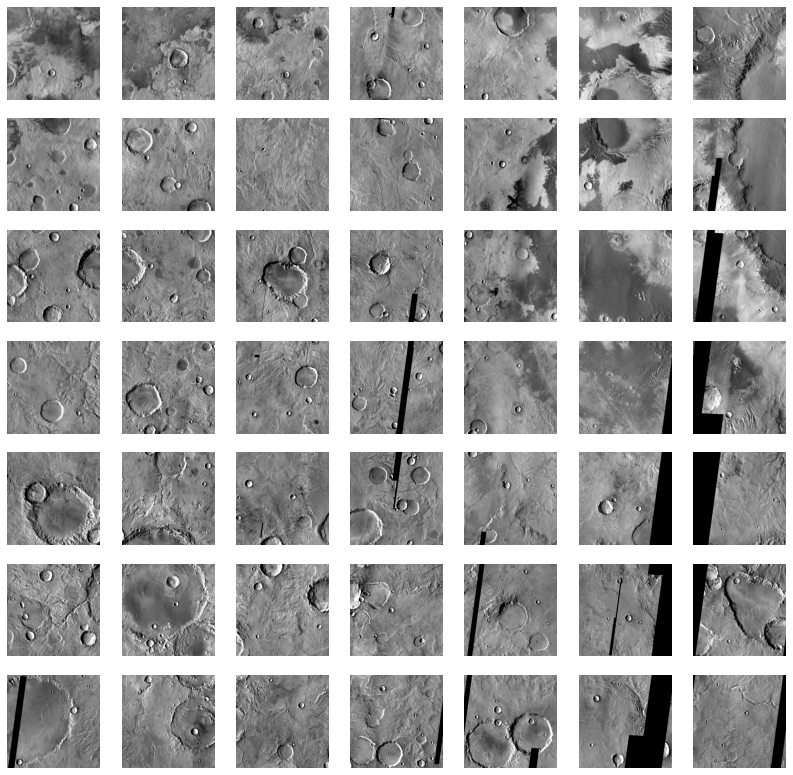

In [41]:
k=1
fig = plt.figure(figsize=(14, 14))

for i in range(7):
  for j in range(7):
    fig.add_subplot(7, 7, k)
    plt.imshow(patches[i,j], cmap='gray')
    plt.axis('off')
    k+=1